# Video Q&A Count Analysis

This notebook analyzes all processed videos and counts how many Q&A items each has. Videos with 0 Q&A items likely don't have timestamps in their descriptions.

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables0
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")

if not DATABASE_URL:
    raise ValueError("DATABASE_URL not found in environment variables")

# Create database connection
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(bind=engine)

print("✓ Database connection established")

✓ Database connection established


## Fetch All Videos with Q&A Counts

In [3]:
def get_all_videos_with_qa_counts():
    """Get all videos with their Q&A item counts."""
    with SessionLocal() as session:
        query = text("""
            SELECT 
                v.youtube_id,
                v.title,
                v.published_at,
                v.status,
                v.processed_at,
                COUNT(qa.id) as qa_count,
                v.url
            FROM videos v
            LEFT JOIN qa_items qa ON v.id = qa.video_id
            GROUP BY v.id, v.youtube_id, v.title, v.published_at, v.status, v.processed_at, v.url
            ORDER BY v.published_at DESC NULLS LAST
        """)
        
        result = session.execute(query)
        rows = result.fetchall()
        
        if not rows:
            print("No videos found in database")
            return None
        
        df = pd.DataFrame(rows, columns=[
            'youtube_id', 'title', 'published_at', 'status', 
            'processed_at', 'qa_count', 'url'
        ])
        
        return df

# Fetch all videos
videos_df = get_all_videos_with_qa_counts()

if videos_df is not None:
    print(f"Total videos in database: {len(videos_df)}")
    print(f"\nStatus breakdown:")
    print(videos_df['status'].value_counts())
    print("\n" + "="*80)

Total videos in database: 69

Status breakdown:
status
processed    69
Name: count, dtype: int64



## Summary Statistics

In [4]:
if videos_df is not None:
    # Filter to processed videos
    processed_df = videos_df[videos_df['status'] == 'processed'].copy()
    
    print(f"Processed videos: {len(processed_df)}")
    print(f"\nQ&A Count Statistics:")
    print(processed_df['qa_count'].describe())
    
    # Count videos by Q&A count ranges
    print("\n" + "="*80)
    print("\nDistribution:")
    print(f"  Videos with 0 Q&As: {len(processed_df[processed_df['qa_count'] == 0])}")
    print(f"  Videos with 1-5 Q&As: {len(processed_df[(processed_df['qa_count'] >= 1) & (processed_df['qa_count'] <= 5)])}")
    print(f"  Videos with 6-10 Q&As: {len(processed_df[(processed_df['qa_count'] >= 6) & (processed_df['qa_count'] <= 10)])}")
    print(f"  Videos with 11+ Q&As: {len(processed_df[processed_df['qa_count'] > 10])}")

Processed videos: 69

Q&A Count Statistics:
count    69.000000
mean     12.507246
std       4.558841
min       3.000000
25%      10.000000
50%      12.000000
75%      15.000000
max      25.000000
Name: qa_count, dtype: float64


Distribution:
  Videos with 0 Q&As: 0
  Videos with 1-5 Q&As: 3
  Videos with 6-10 Q&As: 19
  Videos with 11+ Q&As: 47


## Videos Without Q&A Items

These videos likely don't have timestamps in their descriptions.

In [5]:
if videos_df is not None:
    # Get processed videos with no Q&A items
    no_qa_df = videos_df[
        (videos_df['status'] == 'processed') & 
        (videos_df['qa_count'] == 0)
    ].copy()
    
    print(f"Found {len(no_qa_df)} processed videos with 0 Q&A items\n")
    print("="*80 + "\n")
    
    if len(no_qa_df) > 0:
        # Sort by published date
        no_qa_df = no_qa_df.sort_values('published_at', ascending=False)
        
        # Display the results
        display(no_qa_df[['youtube_id', 'title', 'published_at', 'url']])
        
        # Export to CSV if needed
        # no_qa_df.to_csv('videos_without_qa.csv', index=False)
        # print("\n✓ Exported to videos_without_qa.csv")
    else:
        print("✓ All processed videos have Q&A items!")

Found 0 processed videos with 0 Q&A items


✓ All processed videos have Q&A items!


## All Processed Videos - Sorted by Q&A Count

Complete list sorted from fewest to most Q&A items.

In [6]:
if videos_df is not None:
    processed_df = videos_df[videos_df['status'] == 'processed'].copy()
    processed_df = processed_df.sort_values('qa_count')
    
    print(f"All {len(processed_df)} processed videos sorted by Q&A count:\n")
    display(processed_df[['youtube_id', 'title', 'published_at', 'qa_count', 'url']])

All 69 processed videos sorted by Q&A count:



,youtube_id,title,published_at,qa_count,url
50,Sljw7NAvABw,FRIDAY NIGHT LIVE Couple's Q&A with Tom & Jenn...,2025-01-25 17:06:49+00:00,3,https://www.youtube.com/watch?v=Sljw7NAvABw
66,-NyC8krNuHw,Mailbag Episode! Questions about Deacon Minist...,2024-08-15 20:36:21+00:00,3,https://www.youtube.com/watch?v=-NyC8krNuHw
68,6Ih9uEGeJBI,"Responding to Viewer Emails about communion, c...",2024-05-21 20:38:08+00:00,4,https://www.youtube.com/watch?v=6Ih9uEGeJBI
60,PsCE2s3ftSs,FRIDAY NIGHT LIVE! (Keith Answering Emails & A...,2024-10-26 15:18:09+00:00,6,https://www.youtube.com/watch?v=PsCE2s3ftSs
37,hWbEIgJTLWQ,LIVE Ask Us Anything! with Mr&Mrs Your Calvinist,2025-05-21 03:02:43+00:00,7,https://www.youtube.com/watch?v=hWbEIgJTLWQ
...,...,...,...,...,...
19,COT63o4lau8,LIVE Q&A with Mr&Mrs YourCalvinist (Keith and ...,2025-09-10 03:39:48+00:00,20,https://www.youtube.com/watch?v=COT63o4lau8
18,SdEScHqt_Wk,Live with Keith & Jennifer Foskey (Thoughts on...,2025-09-17 03:28:29+00:00,20,https://www.youtube.com/watch?v=SdEScHqt_Wk
11,HYGaljrmrVY,LIVE Q&A w Keith & Jennifer Foskey @YourCalvinist,2025-10-31 03:41:38+00:00,23,https://www.youtube.com/watch?v=HYGaljrmrVY
9,KZeoH99_eBQ,LIVE with Keith & Jen Foskey @YourCalvinists,2025-11-12 04:42:40+00:00,24,https://www.youtube.com/watch?v=KZeoH99_eBQ


## Visualizations

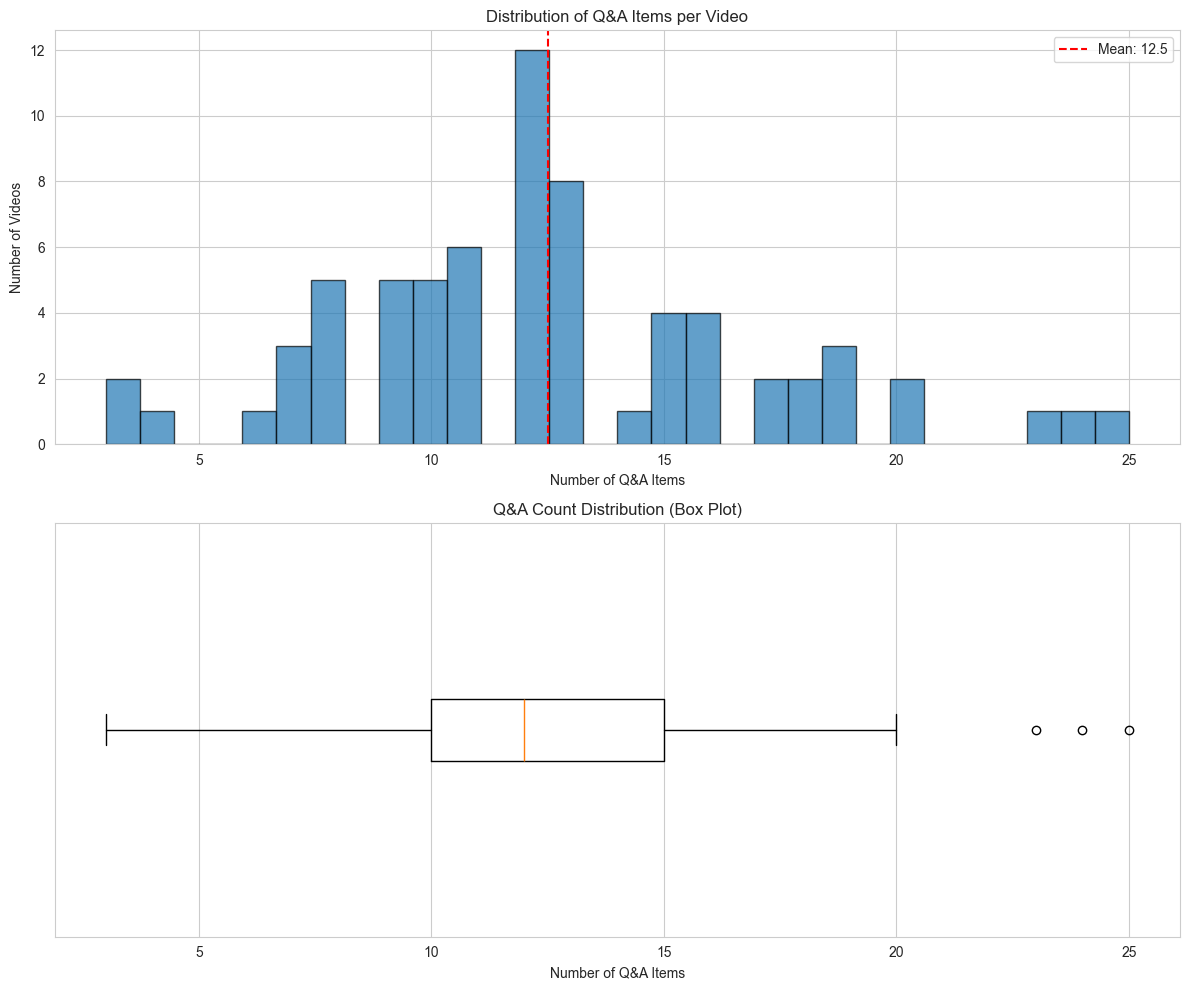



Top 10 videos by Q&A count:


,title,qa_count,published_at
17,Friday Night Live Q&A w/Mr&Mrs YourCalvinist,25,2025-09-27 04:13:38+00:00
9,LIVE with Keith & Jen Foskey @YourCalvinists,24,2025-11-12 04:42:40+00:00
11,LIVE Q&A w Keith & Jennifer Foskey @YourCalvinist,23,2025-10-31 03:41:38+00:00
18,Live with Keith & Jennifer Foskey (Thoughts on...,20,2025-09-17 03:28:29+00:00
19,LIVE Q&A with Mr&Mrs YourCalvinist (Keith and ...,20,2025-09-10 03:39:48+00:00
3,Last Live of '25! with Keith & Jen Foskey @You...,19,2025-12-31 04:34:33+00:00
4,Live with Keith & Jen Foskey (@YourCalvinist),19,2025-12-17 04:31:44+00:00
28,Tuesday Night Live Q&A w/Mr&Mrs YourCalvinist,19,2025-07-09 03:14:53+00:00
0,YourCalvinist LIVE with Keith & Jennifer Foskey,18,2026-01-21 04:41:18+00:00
38,Tuesday Night Live ASK US ANYTHING!,18,2025-05-14 03:21:26+00:00


In [7]:
if videos_df is not None:
    processed_df = videos_df[videos_df['status'] == 'processed'].copy()
    
    # Set up the plotting style
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Histogram of Q&A counts
    axes[0].hist(processed_df['qa_count'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Number of Q&A Items')
    axes[0].set_ylabel('Number of Videos')
    axes[0].set_title('Distribution of Q&A Items per Video')
    axes[0].axvline(processed_df['qa_count'].mean(), color='red', linestyle='--', label=f'Mean: {processed_df["qa_count"].mean():.1f}')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(processed_df['qa_count'], vert=False)
    axes[1].set_xlabel('Number of Q&A Items')
    axes[1].set_title('Q&A Count Distribution (Box Plot)')
    axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Top videos by Q&A count
    print("\n" + "="*80)
    print("\nTop 10 videos by Q&A count:")
    top_videos = processed_df.nlargest(10, 'qa_count')[['title', 'qa_count', 'published_at']]
    display(top_videos)

## Export Data

Export videos without Q&A to CSV for further processing.

In [8]:
# Uncomment to export

# if videos_df is not None:
#     no_qa_df = videos_df[
#         (videos_df['status'] == 'processed') & 
#         (videos_df['qa_count'] == 0)
#     ].copy()
    
#     if len(no_qa_df) > 0:
#         no_qa_df.to_csv('videos_without_qa.csv', index=False)
#         print(f"✓ Exported {len(no_qa_df)} videos to videos_without_qa.csv")
    
#     # Also export full list
#     processed_df = videos_df[videos_df['status'] == 'processed'].copy()
#     processed_df.to_csv('all_processed_videos_with_counts.csv', index=False)
#     print(f"✓ Exported {len(processed_df)} videos to all_processed_videos_with_counts.csv")